# $\phi_1 = \frac{I\rho}{4\pi R} + \sum_{n=0}^{\infty} A_n r^{-(n+1)}P_n (cos\theta)$

# $\phi_1 = \sum_{n=0}^{\infty} B_n r^n P_n (cos\theta)$

In [1]:
import numpy as np
from scipy import special
from SimPEG import Mesh

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

In [4]:
hx = np.ones(80)*0.5
hz = np.ones(40)*0.5
mesh = Mesh.TensorMesh([hx, np.r_[0.], hz], "CCN")
mesh2D = Mesh.TensorMesh([hx, hz], "CN")

In [7]:
deg2rad  = lambda deg: deg/180.*np.pi
rad2deg  = lambda rad: rad*180./np.pi

def AnBnfun(n, radius, x0, rho, rho1, I=1.):
    const = I*rho/(4*np.pi)
    bunmo = n*rho + (n+1)*rho1
    An = const * radius**(2*n+1) / x0 ** (n+1.) * n * (rho1-rho) / bunmo
    Bn = const * 1. / x0 ** (n+1.) * (2*n+1) * (rho1) / bunmo
    return An, Bn

In [8]:
def fieldsSingle(txloc, rxloc, radius, rho, rho1, flag = "sec", order=12):
# def fields(txloc, radius, rho, rho1, flag = "sec"):
    """
        Parameters
            txloc: current electrode location (x,y,z)
            radius: radius of the sphere (m)
            rho: resistivity of the background (ohm-m)
            rho1: resistivity of the sphere
            flag: "sec", "total", "prim"
            order: maximum order of Legendre polynomial

    """
    Pleg = []
    for i in range(order):
        Pleg.append(special.legendre(i, monic=0))    
        
    ispos = txloc[0] > 0.
    
    if ispos == True:
        sign = 1.
    else:
        sign = -1.
            
    r = np.sqrt((rxloc**2).sum(axis=1))
    costheta = rxloc[:,0]/r
    phi = np.zeros_like(r)
    R = (r**2+txloc[0]**2.-2.*r*txloc[0]*costheta)**0.5    
    prim = rho*1./(4*np.pi*R)
    if flag =="prim":
        return prim
    
    sphind = r < radius
    out = np.zeros_like(r)    
    for n in range(order):
        An, Bn = AnBnfun(n, radius, txloc[0], rho, rho1)
        dumout = sign*An*r[~sphind]**(-n-1.)*Pleg[n](costheta[~sphind])
        out[~sphind] += dumout
        dumin = sign*Bn*r[sphind]**(n)*Pleg[n](costheta[sphind])    
        out[sphind] += dumin
        if n==0:
            out[sphind] -= prim[sphind]       
    
    if flag == "sec":
        return out            
    
    elif flag == "total":
        out[~sphind] += prim[~sphind]        
        return out

In [9]:
from ipywidgets import interact, IntSlider

In [10]:
sig1, sig2 = 1e-3, 1e-8
rho = 1./sig1
rho1 = 1./sig2
# rho, rho1 = 1e3, 1e0
radius = 6
txlocA = np.r_[ -30., 0., 0.]
txlocB = np.r_[ 30., 0., 0.]
rxlocM = np.c_[mesh.gridCC[:,0]-0.5, mesh.gridCC[:,1], mesh.gridCC[:,2]]
rxlocN = np.c_[mesh.gridCC[:,0]+0.5, mesh.gridCC[:,1], mesh.gridCC[:,2]]
phiAM = fieldsSingle(txlocA,rxlocM,radius, rho, rho1, flag = "sec")
phiAN = fieldsSingle(txlocA,rxlocN,radius, rho, rho1, flag = "sec")
phiBM = fieldsSingle(txlocB,rxlocM,radius, rho, rho1, flag = "sec")
phiBN = fieldsSingle(txlocB,rxlocN,radius, rho, rho1, flag = "sec")

In [11]:
phiA = fieldsSingle(txlocA,mesh.gridCC,radius, rho, rho1, flag = "sec")
phiB = fieldsSingle(txlocB,mesh.gridCC,radius, rho, rho1, flag = "sec")
phisec = phiA-phiB
phiAprim = fieldsSingle(txlocA,mesh.gridCC,radius, rho, rho1, flag = "prim")
phiBprim = fieldsSingle(txlocB,mesh.gridCC,radius, rho, rho1, flag = "prim")
phiprim = phiAprim-phiBprim
phitot = phisec+phiprim

In [12]:
X = mesh2D.gridCC[:,0].reshape(mesh2D.vnC, order='F')
Y = mesh2D.gridCC[:,1].reshape(mesh2D.vnC, order='F')

In [13]:
colormap = 'RdPu'
# colormap = 'seismic'

<matplotlib.colorbar.Colorbar instance at 0x1078d2710>

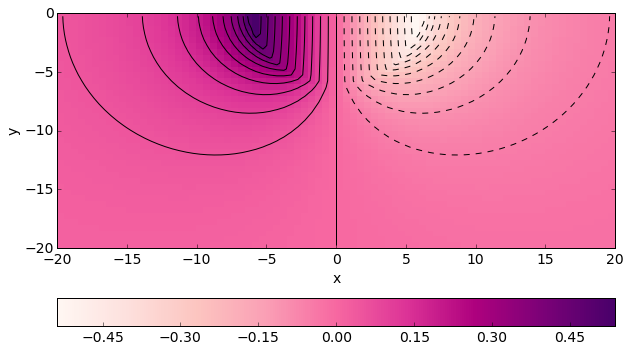

In [14]:
figsize(10, 6)
dat = mesh2D.plotImage(phisec, pcolorOpts={'cmap':colormap})
PHISEC = phisec.reshape(mesh2D.vnC, order='F')
plt.contour(X, Y, PHISEC, 25, colors='k', lindewidth=0.5)
plt.colorbar(dat[0], orientation="horizontal")


<matplotlib.colorbar.Colorbar instance at 0x107c3d098>

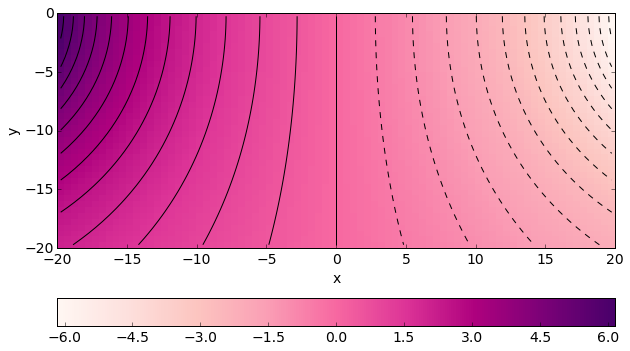

In [15]:
figsize(10, 6)
dat = mesh2D.plotImage(phiprim, pcolorOpts={'cmap':colormap})
PHIPRIM = phiprim.reshape(mesh2D.vnC, order='F')
plt.contour(X, Y, PHIPRIM, 25, colors='k', lindewidth=0.5)
plt.colorbar(dat[0], orientation="horizontal")

<matplotlib.colorbar.Colorbar instance at 0x108111170>

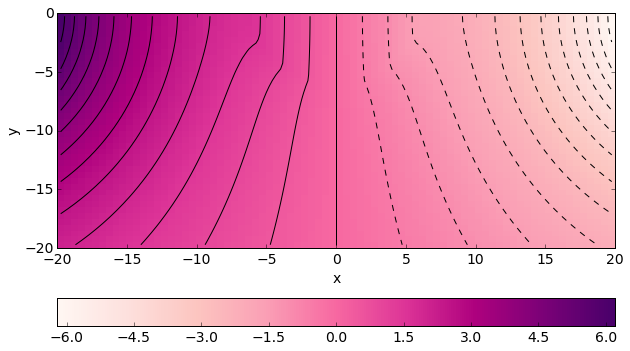

In [16]:
figsize(10, 6)
dat = mesh2D.plotImage(phitot, pcolorOpts={'cmap':colormap})
PHI = phitot.reshape(mesh2D.vnC, order='F')
plt.contour(X, Y, PHI, 25, colors='k', lindewidth=0.5)
plt.colorbar(dat[0], orientation="horizontal")

In [17]:
from scipy import constants

In [18]:
mesh2D.setCellGradBC('neumann')
G = mesh2D.cellGrad
Div = mesh2D.faceDiv
e = -G*phitot
eprim = -G*phiprim
esec = e-eprim
charge = -G.T*esec*constants.epsilon_0

In [19]:
charge.min()

-5.7916816312554758e-12

<matplotlib.colorbar.Colorbar instance at 0x10896b050>

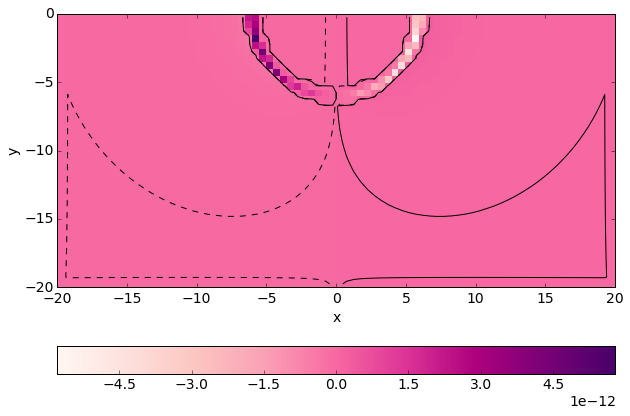

In [20]:
figsize(10, 7)
dat = mesh2D.plotImage(charge, pcolorOpts={'cmap':colormap})
CHARGE = charge.reshape(mesh2D.vnC, order='F')
CS = plt.contour(X, Y, CHARGE, np.r_[-0.3, 0.3]*1e-14, colors='k', lw=3)
plt.colorbar(dat[0], orientation="horizontal")
# plt.clabel(CS, )

In [51]:
sphind = np.sqrt((mesh.gridCC**2).sum(axis=1)) < radius
sigma = 1./rho*np.ones(mesh.nC)
MfSigprim = mesh2D.getFaceInnerProduct(sigma)
sigma[sphind] = 1./rho1
MfSig = mesh2D.getFaceInnerProduct(sigma)

In [52]:
Mfinv = mesh2D.getFaceInnerProduct(invMat=True)

In [53]:
j = Mfinv*MfSig*e
jprim = Mfinv*MfSigprim*eprim
jsec = j-jprim

In [56]:
def slicer(i):
    dat = mesh.plotSlice(e, vType="F", ind=i, view='vec', streamOpts={'color':'w'})
    plt.colorbar(dat[0])
    return 

<matplotlib.colorbar.Colorbar instance at 0x10e323ef0>

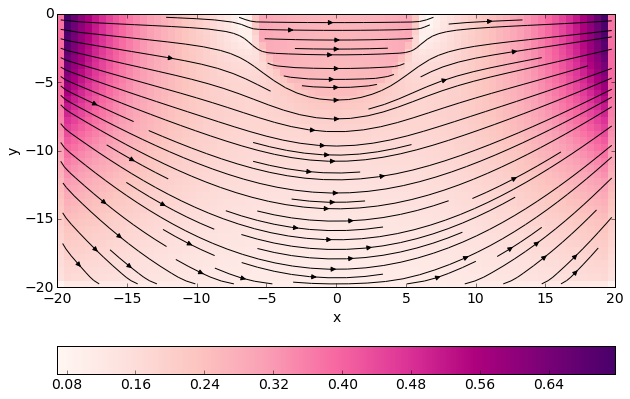

In [61]:
figsize(10, 7)
# dat = mesh2D.plotImage(esec, vType="F", view='vec', streamOpts={'color':'w'}, pcolorOpts={'cmap':colormap})
dat = mesh2D.plotImage(e, vType="F", view='vec', streamOpts={'color':'K'}, pcolorOpts={'cmap':colormap})
plt.colorbar(dat[0], orientation="horizontal")

<matplotlib.colorbar.Colorbar instance at 0x10dbe3d88>

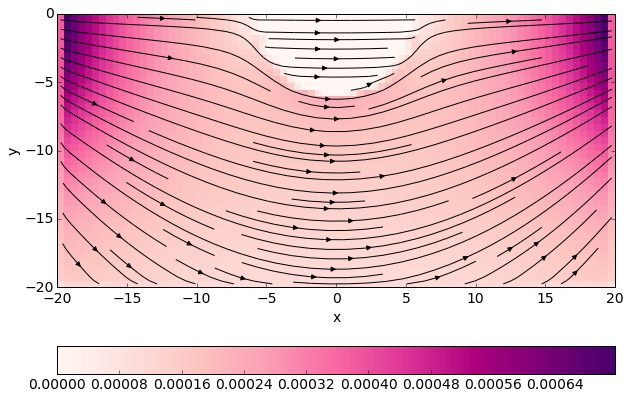

In [60]:
figsize(10, 7)
dat = mesh2D.plotImage(j, vType="F", view='vec', streamOpts={'color':'K'}, pcolorOpts={'cmap':colormap})
# dat = mesh2D.plotImage(jsec, vType="F", view='vec', streamOpts={'color':'K'}, pcolorOpts={'cmap':colormap})
plt.colorbar(dat[0], orientation="horizontal")